## Подключение библиотек и модулей

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib

from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Пути к файлам

In [2]:
TRAIN_PATH = 'train.csv'
PREPARED_TRAIN_PATH = 'train_prepared.csv'
TEST_PATH = 'test.csv'

## Функции и классы

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

## Ввод данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
train_df = pd.read_csv(TRAIN_PATH, sep = ',')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

Оптимизация типов данных  для уменшения размера

In [7]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [8]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


In [9]:
train_df.dtypes

Id               category
DistrictId       category
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

### EDA (Визуализация)

In [10]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

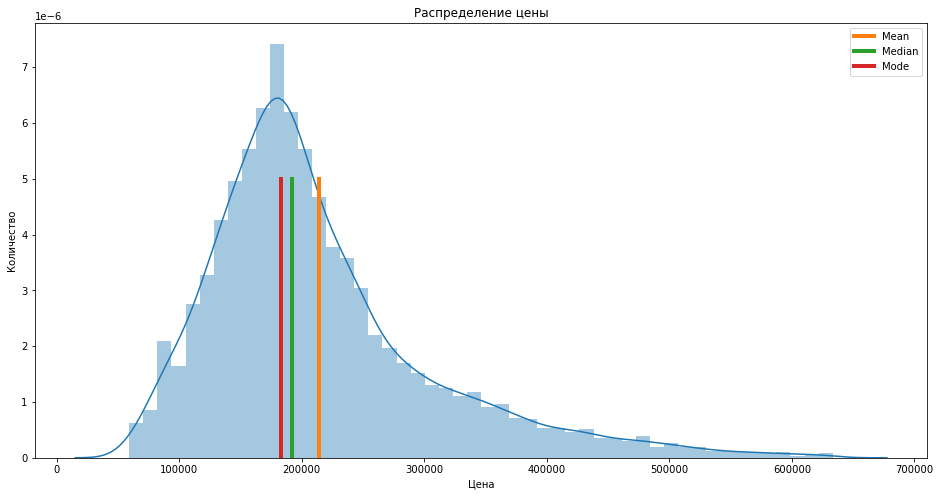

In [11]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='Mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='Median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Mode', linewidth=4)

plt.ylabel('Количество')
plt.xlabel('Цена')

plt.title('Распределение цены')
plt.legend()
plt.show()

In [12]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'float32', 'float16', 'int8', 'int16', 'int32'])
train_df_num_features.drop('Price', axis=1, inplace=True)
train_df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11
1,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16
2,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3
3,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5
4,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,50.401787,30.476204,5.0,6,5.0,1968,0.135650,46,7960,6,350.0,3,11
9996,1.0,41.521545,20.539215,9.0,13,13.0,2000,0.000000,30,5562,0,NaN,0,5
9997,1.0,47.939007,NaN,1.0,12,16.0,2015,0.072158,2,629,1,NaN,0,0
9998,2.0,43.602562,33.840149,8.0,1,5.0,1961,0.307467,30,5048,9,325.0,2,5


### Количественные признаки

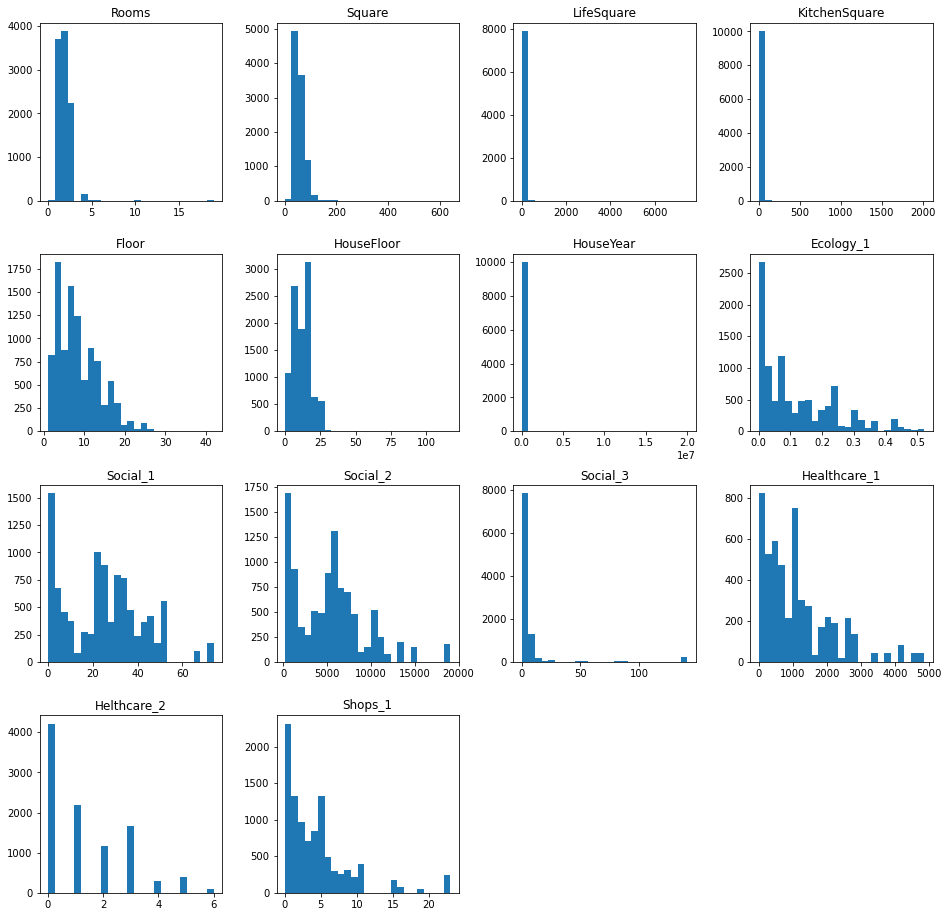

In [13]:
train_df_num_features.hist(figsize=(16,16), bins=25, grid=False);

In [14]:
train_df_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


### Категориальные признаки

In [16]:
cat_features_names = train_df.select_dtypes(include='category').columns.tolist()
cat_features_names

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [18]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [19]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Построение функции для обработки данных

In [20]:
class DataPreproc:
    
    def __init__(self):
        self.medians = None
        self.min_quantile = None
        self.max_quantile = None
            
    def fit(self, df):
        self.min_quantile=df.quantile(q=0.025)
        self.max_quantile=df.quantile(q=0.025)
        self.medians = df.median()
        
        self.binary_to_numbers = {'A': 0, 'B': 1}
                
    def transform(self, df):
        #заполнение пропусков
        df.fillna(self.medians, inplace=True)
        
        
        
        #работа с выбросами
        #rooms
        condition = (df['Rooms'] > self.min_quantile['Rooms']) | (df['Rooms'] < self.max_quantile['Rooms'])
        df.loc[condition, 'Rooms'] = self.medians['Rooms']
        
        #Square
        condition = (df['Square'] > self.min_quantile['Square']) | (df['Square'] < self.max_quantile['Square'])
        df.loc[condition, 'Square'] = self.medians['Square']
        
        
        #Floor, HouseFloor
        df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor']
        
        #HouseYear
        df.loc[df['HouseYear'] > 2020, 'HouseYear'] = 2020
        
        #Social_2, Social_3
        condition = (df['Social_2'] > self.min_quantile['Social_2']) | (df['Social_2'] < self.max_quantile['Social_2'])
        df.loc[condition, 'Social_2'] = self.medians['Social_2']
        condition = (df['Social_3'] > self.min_quantile['Social_3']) | (df['Social_3'] < self.max_quantile['Social_3'])
        df.loc[condition, 'Social_3'] = self.medians['Social_3']
        
        #Healthcare_1
        condition = (df['Healthcare_1'] > self.min_quantile['Healthcare_1']) | (df['Healthcare_1'] < self.max_quantile['Healthcare_1'])
        df.loc[condition, 'Healthcare_1'] = self.medians['Healthcare_1']
        
        #Shops_1
        condition = (df['Shops_1'] > self.min_quantile['Shops_1']) | (df['Shops_1'] < self.max_quantile['Shops_1'])
        df.loc[condition, 'Shops_1'] = self.medians['Shops_1']
        
        #Категориальные признаки
        
        df['Ecology_2'] = df['Ecology_2'].map(self.binary_to_numbers)
        df['Ecology_3'] = df['Ecology_3'].map(self.binary_to_numbers)
        df['Shops_2'] = df['Shops_2'].map(self.binary_to_numbers)
        
        #дополнительные признаки
        district_size = df['DistrictId'].value_counts().reset_index().rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        df = df.merge(district_size, on='DistrictId', how='left')
        
        #удаляем признаки
        df.drop('Id', axis=1, inplace=True)
        df.drop('DistrictId', axis=1, inplace=True)
        

        
        return df

## Разбиение на train и test

In [21]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'district_size']

In [22]:
feature_names = ['Id', 'DistrictId', 'Rooms', 'Square',
                 'LifeSquare',
                 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 
                 'Ecology_2', 'Ecology_3',
                 'Social_1', 'Social_2', 'Social_3', 
                  'Healthcare_1',
                 'Helthcare_2',
                 'Shops_1', 
                 'Shops_2'
                ]
new_features =['district_size']
target_name = 'Price'

In [45]:
X = train_df[feature_names + new_features]
y = train_df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [46]:
prep = DataPreproc()
prep.fit(X_train)
X_train_prep = prep.transform(X_train)
prep.fit(X_valid)
X_valid_prep = prep.transform(X_valid)

## Построение модели

R2:	0.372
RMSE:	73652.505
MSE:	5424691551.572


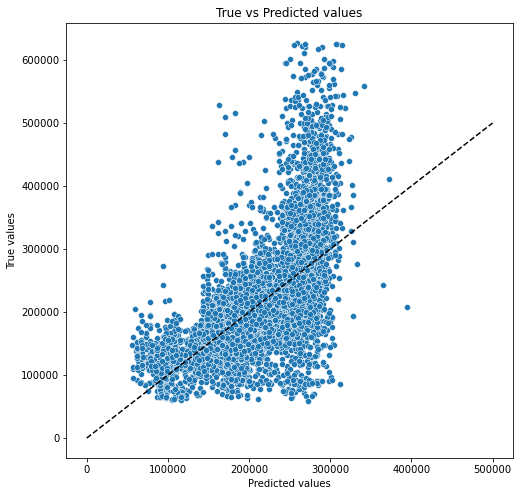

In [47]:
lr_model = LinearRegression()
lr_model.fit(X_train_prep, y_train)
y_train_preds = lr_model.predict(X_train_prep)
evaluate_preds(y_train, y_train_preds)

R2:	0.295
RMSE:	77884.38
MSE:	6065976710.128


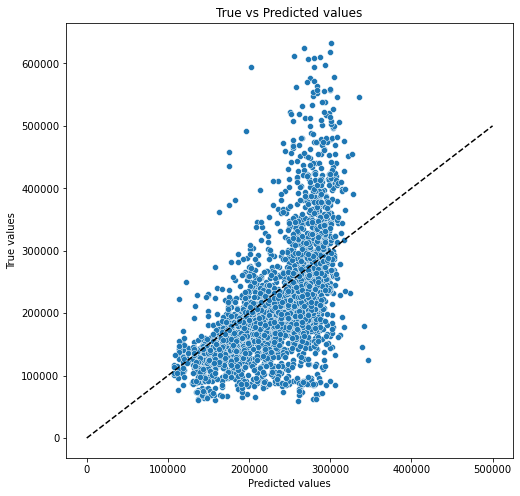

In [48]:
y_valid_preds = lr_model.predict(X_valid_prep)
evaluate_preds(y_valid, y_valid_preds)

## Оценка качества модели